In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F

In [65]:
OUTPUT_fig = 'output/fig'
OUTPUT_csv = 'output/csv'
os.makedirs(OUTPUT_csv, exist_ok=True)
os.makedirs(OUTPUT_fig, exist_ok=True)

#train data set
logo_df = pd.read_csv('data/logo.csv')
x_train = logo_df.to_numpy()
t_train = np.zeros((x_train.shape[0], 1))

class dataset(torch.utils.data.Dataset):
    def __init__(self, x_train, t_train):
        self.x_train = x_train.astype('float32')
        self.t_train = t_train
    
    def __len__(self):
        return self.x_train.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.x_train[idx], dtype=torch.float), torch.tensor(t_train[idx], dtype=torch.long)

trainval_data = dataset(x_train, t_train)

In [66]:
batch_size = 32
val_size = 1000
train_size = len(trainval_data) - val_size

train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle = True
)
dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size = batch_size,
    shuffle = True
)

In [67]:
def init_weights_xav(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.0)

def init_weights_he(m):  # He
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)

class deepSDF(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Linear(in_dim, 6),
            nn.BatchNorm1d(6),
            nn.ReLU(),
            nn.Linear(6, 12),
            nn.BatchNorm1d(12),
            nn.ReLU(),

            nn.Linear(12, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 12),
            nn.BatchNorm1d(12),
            nn.ReLU(),
            nn.Linear(12, 6),
            nn.BatchNorm1d(6),
            nn.ReLU(),
            nn.Linear(6, 3),
            nn.BatchNorm1d(3),
            nn.ReLU(),

            nn.Linear(3, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.Tanh()
        ).apply(init_weights_he)

        

    def forward(self, x):
        return self.layer(x)

    def sdf(self, x):
        x = x.reshape((3,))
        x = torch.tensor(x, dtype=torch.float, requires_grad=True).unsqueeze(0)
        x.retain_grad()
        y = self.layer(x)
        y.backward()

        vec_n = 100*x.grad.to('cpu').detach().numpy().copy().reshape((3,1))
        return y.item(), vec_n/np.linalg.norm(vec_n)



def loss_function(y, t, delta=0.1):
    y_cl = torch.clamp(y, min=-delta, max=delta)
    t_cl = torch.clamp(t, min=-delta, max=delta)

    return torch.abs(y_cl - t_cl).sum()


lr = 5e-3
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = deepSDF(3,1).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [68]:
n_epochs = 3

for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []

    model.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]
        model.zero_grad()
        x = x.to(device)
        t = t.to(device)
        y = model(x)
        loss = loss_function(y, t)

        loss.backward()
        optimizer.step()

        acc_train += (torch.abs(y) < torch.tensor(0.05)).float().sum().item()
        losses_train.append(loss.tolist())

    model.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]
        model.zero_grad()
        x = x.to(device)
        t = t.to(device)
        y = model(x)
        loss = loss_function(y, t)

        acc_val += (torch.abs(y) < torch.tensor(0.05)).float().sum().item()
        losses_valid.append(loss.tolist())

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
        epoch,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val
    ))  

EPOCH: 0, Train [Loss: 2.106, Accuracy: 0.386], Valid [Loss: 0.995, Accuracy: 0.715]
EPOCH: 1, Train [Loss: 0.373, Accuracy: 0.917], Valid [Loss: 0.040, Accuracy: 1.000]
EPOCH: 2, Train [Loss: 0.029, Accuracy: 1.000], Valid [Loss: 0.030, Accuracy: 1.000]
EPOCH: 3, Train [Loss: 0.030, Accuracy: 1.000], Valid [Loss: 0.012, Accuracy: 1.000]
EPOCH: 4, Train [Loss: 0.027, Accuracy: 1.000], Valid [Loss: 0.018, Accuracy: 1.000]
EPOCH: 5, Train [Loss: 0.028, Accuracy: 1.000], Valid [Loss: 0.065, Accuracy: 1.000]
EPOCH: 6, Train [Loss: 0.027, Accuracy: 1.000], Valid [Loss: 0.012, Accuracy: 1.000]
EPOCH: 7, Train [Loss: 0.023, Accuracy: 1.000], Valid [Loss: 0.036, Accuracy: 1.000]
EPOCH: 8, Train [Loss: 0.021, Accuracy: 1.000], Valid [Loss: 0.016, Accuracy: 1.000]
EPOCH: 9, Train [Loss: 0.020, Accuracy: 1.000], Valid [Loss: 0.020, Accuracy: 1.000]
EPOCH: 10, Train [Loss: 0.018, Accuracy: 1.000], Valid [Loss: 0.009, Accuracy: 1.000]
EPOCH: 11, Train [Loss: 0.024, Accuracy: 1.000], Valid [Loss: 0.

In [69]:
for i in range(2):
    i += 500
    print(x_train[i])
    x = torch.tensor(x_train[i], dtype=torch.float, requires_grad=True)
    y, n = model.sdf(x_train[i].reshape((3,1)))
    print(y)
    print(n)



[0.2279152  0.33215547 0.        ]
-0.011348790489137173
[[-0.13036087]
 [-0.8659122 ]
 [ 0.48291007]]
[0.29681978 0.23144877 0.06315789]
-0.0014312644489109516
[[-0.13441129]
 [-0.83066267]
 [ 0.54030836]]


In [61]:
def rel_Lambert(I, x, l_point, n, k_d):
    xl = l_point - x
    r = np.linalg.norm(xl)
    l = xl/r

    return k_d*(I/r**2)*max(0, np.dot(l.T, n)[0][0])

def rel_environment(I_a, k_a):
    return k_a*I_a

def raymarching(ray, forcus, sdf):
    beta = 0.05
    vec_ray = beta*(ray/np.linalg.norm(ray))
    x = forcus + vec_ray
    dist, vec_n= sdf(x)

    flag = True
    step = 0
    while -1e-1 > dist or dist > 1e-1:
        
        pre_dist = dist
        if dist > 0:
            x = x + vec_ray
            dist, vec_n = sdf(x)
        else:
            x = x - 0.01*vec_ray
            dist, vec_n = sdf(x)
            flag = False


        if flag and pre_dist < dist: #no material is same return
            return forcus, np.zeros((3,1))

        if step == 20:
            return forcus, np.zeros((3,1))

        step += 1

    return x, vec_n

In [62]:
#rotation transration
theta = 45
cos = np.cos(np.radians(theta))
sin = np.sin(np.radians(theta))
R = [[1, 0, 0],
     [0, cos, -sin],
     [0, sin, cos]]
R = np.array(R)
T = [1, -2.5, 2.5]
T = np.array(T).reshape((3,1))
A = np.append(R, T, axis=1)
#camera
camera = [0,0,0,1]
camera = np.array(camera).reshape((4,1))
camera = np.dot(A, camera)
#screen
screen = np.zeros((500,500))
#camera matrix
K = np.eye(3)
f_x = 20
f_y = 20
K[0,0] = f_x
K[1,1] = f_y
K[0,2] = 250
K[1,2] = 250
#parameter
I = 5
k_d = 10
I_a = 1
k_a = 1

print(x_train.mean(axis=0))
print(x_train.max())


[ 0.03697421 -0.00428233  0.09993895]
0.41342756


In [63]:
width = int(screen.shape[0]/2)
hight = int(screen.shape[1]/2)
n_find = 0
for i in tqdm(range(-width, width)):
    i = i/f_x
    for j in range(-hight, hight):
        j = j/f_y
        forcus = [i, j, 1, 1]
        forcus = np.array(forcus).reshape((4,1))
        forcus_camera = forcus[:3,:]
        forcus = np.dot(A, forcus)
        ray = forcus - camera
        x, vec_n = raymarching(ray, forcus, model.sdf)

        if np.array_equal(forcus, x):
            vec_sc = np.dot(K, forcus_camera)
            screen[int(vec_sc[0][0]), int(vec_sc[1][0])] = 0
        else:
            n_find += 1
            vec_sc = np.dot(K, forcus_camera)
            screen[int(vec_sc[0][0]), int(vec_sc[1][0])] = rel_Lambert(I, x, camera, vec_n, k_d) + rel_environment(I_a,k_a)
            #print(rel_Lambert(I, x, camera, vec_n, k_d))
    
print(n_find)

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-40-3e335a73b7fc>:54: RuntimeWarning: invalid value encountered in true_divide
  return y.item(), vec_n/np.linalg.norm(vec_n)
  0%|          | 1/500 [00:23<3:16:08, 23.58s/it]


KeyboardInterrupt: 

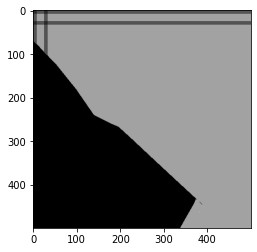

In [58]:
%matplotlib inline
plt.imshow(screen.T, 'gray')
plt.imsave(OUTPUT_fig+'/ex3_100_45.jpg', screen.T)
#plt.savefig(OUTPUT_fig+'ex3_1.jpg')
plt.show()